### Import Necessary Libraries

In [1]:
import os
import re
import torch
import numpy as np
import torch.nn as nn
from PIL import Image
from tqdm import tqdm
from astropy.io import fits
import matplotlib.pyplot as plt
import torchvision.models as models
from torchvision.transforms import v2
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score

### Gather FITS Dataset

In [2]:
dataset = "../continuum_data_subset"
listDir = os.listdir(dataset)

listDir = sorted(listDir, key=lambda x: int(re.search(r'planet(\d+)_', x).group(1)))

imgList, planetNum = [], []

for i in range(len(listDir)):
    hdu = fits.open(os.path.join(dataset, listDir[i]))
    img = hdu[0].data[0].squeeze()
    img = (img - img.min()) / (img.max() - img.min())
    img = (img * 255).astype(np.uint8)
    imgList.append(img)
    planetNum.append(int(re.search(r'planet(\d+)_', listDir[i]).group(1)))

imgList = np.array(imgList)
planetNum = np.array(planetNum)

### Plot for Visual Inspection

In [3]:
print(f"Unique planets by number: {np.unique(planetNum).shape[0]}")

Unique planets by number: 73


In [ ]:
def plot(mul):
    num = 15
    fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(15, 8))

    for i in range(num*mul, num*(mul+1)):
        i -= num * mul
        ax[i//5, i%5].imshow(imgList[i+num*mul], cmap="gray")
        ax[i//5, i%5].set_title(f"Planet: {planetNum[i+num*mul]}")
    fig.tight_layout()

for i in range(10):
    plot(i)
plt.show()

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.vit_b_16(weights="ViT_B_16_Weights.DEFAULT")
model.conv_proj = nn.Conv2d(in_channels=1, out_channels=768, kernel_size=16, stride=16)
model = model.to(device)

In [15]:
transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

imgTensor = []
for img in imgList:
    img_pil = Image.fromarray(img.astype('float32')).convert('L')
    transformImg = transform(img_pil)
    imgTensor.append(transformImg)

imgTensor = torch.tensor(np.array(imgTensor), dtype=torch.float32)

In [16]:
featureTensors = []
model.eval()
with torch.no_grad():
    for i in range(0, imgTensor.shape[0]):
        batchImg = imgTensor[i].unsqueeze(0).to(device)
        features = model(batchImg)
        featureTensors.append(features.squeeze().cpu().numpy().flatten())

featureTensors = np.array(featureTensors)

Cluster 15 with highest silhouette score : 0.31517311930656433
Cluster 15 with lowest Davies-Bouldin index: 1.0658983716175474


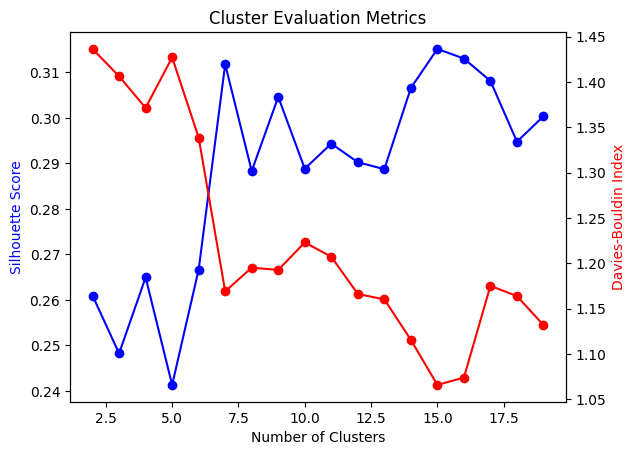

In [17]:
sil_scores = []
db_scores = []
cluster_range = range(2, 20)

for k in cluster_range:
    gmm = GaussianMixture(n_components=k, covariance_type="full", random_state=42)
    labels = gmm.fit_predict(featureTensors)
    
    sil_scores.append(silhouette_score(featureTensors, labels))
    db_scores.append(davies_bouldin_score(featureTensors, labels))

fig, ax1 = plt.subplots()

ax1.plot(cluster_range, sil_scores, 'bo-', label='Silhouette Score')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Silhouette Score', color='b')

ax2 = ax1.twinx()
ax2.plot(cluster_range, db_scores, 'ro-', label='Davies-Bouldin Index')
ax2.set_ylabel('Davies-Bouldin Index', color='r')

print(f"Cluster {np.argmax(sil_scores[1:], )+3} with highest silhouette score : {np.max(sil_scores[1:])}")
print(f"Cluster {np.argmin(db_scores[1:], )+3} with lowest Davies-Bouldin index: {np.min(db_scores[1:])}")

plt.title("Cluster Evaluation Metrics")
plt.show()

In [18]:
num_clusters = 15
gmm = GaussianMixture(n_components=num_clusters, covariance_type="full", random_state=42)
labels = gmm.fit_predict(featureTensors)

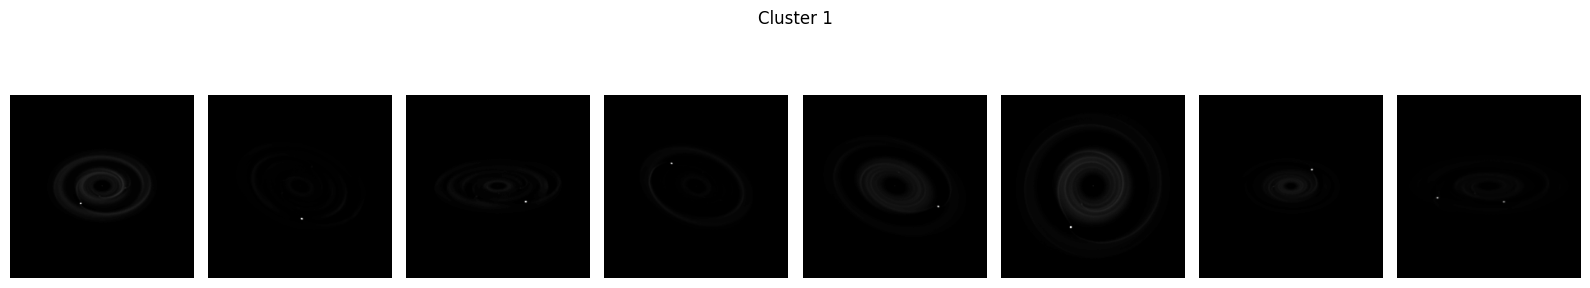

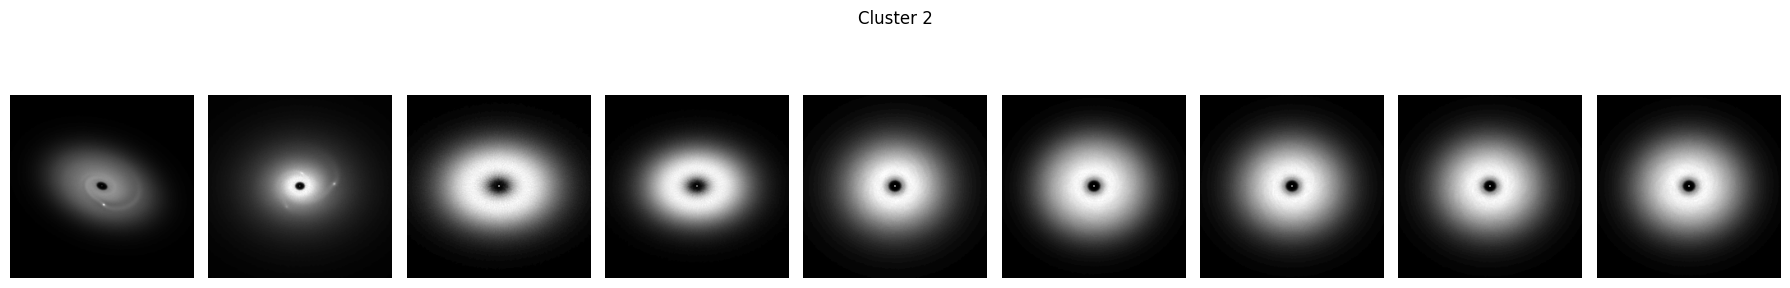

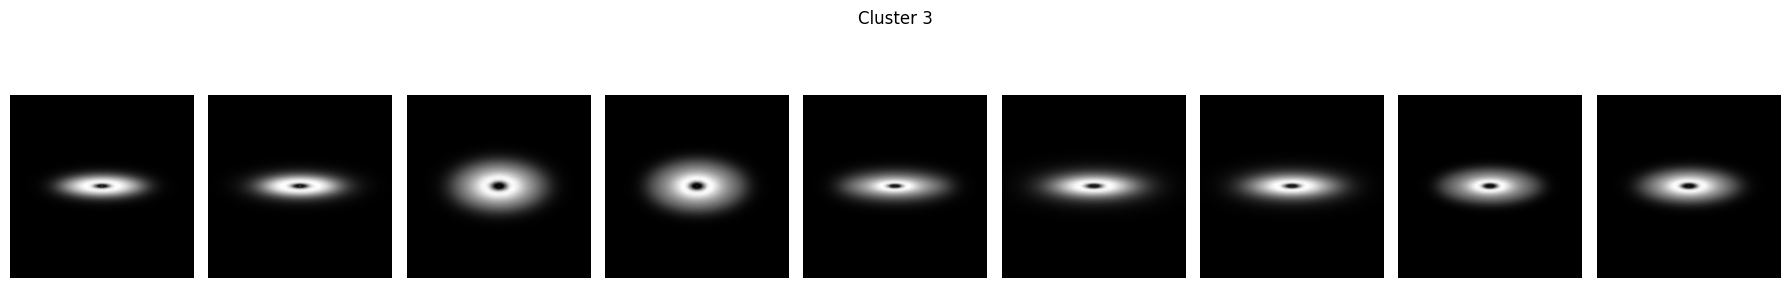

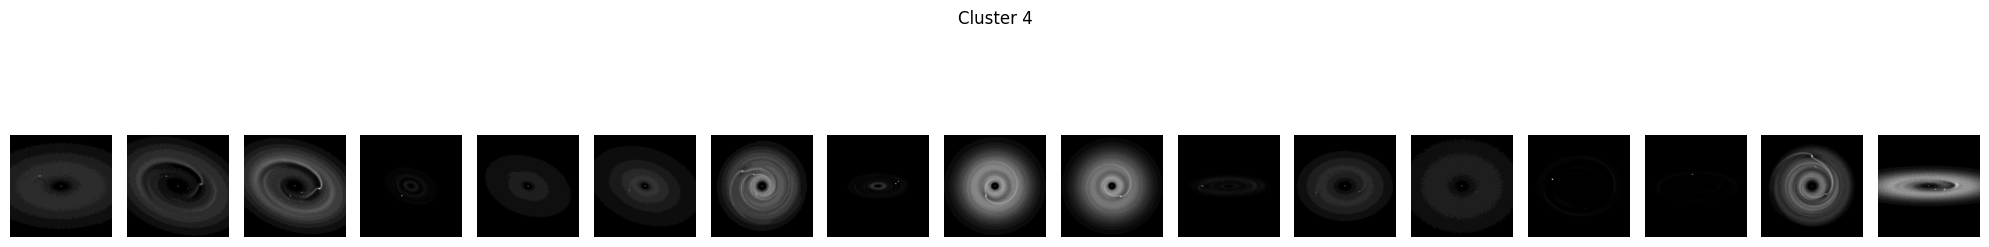

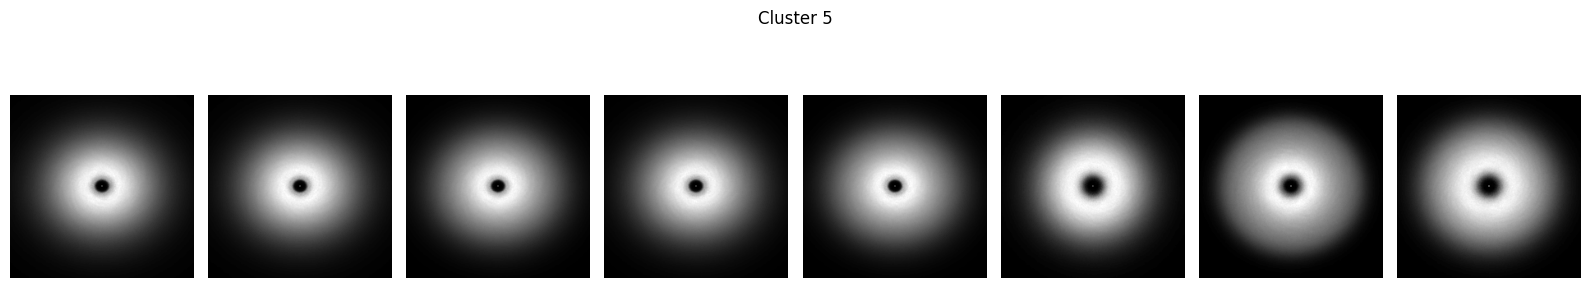

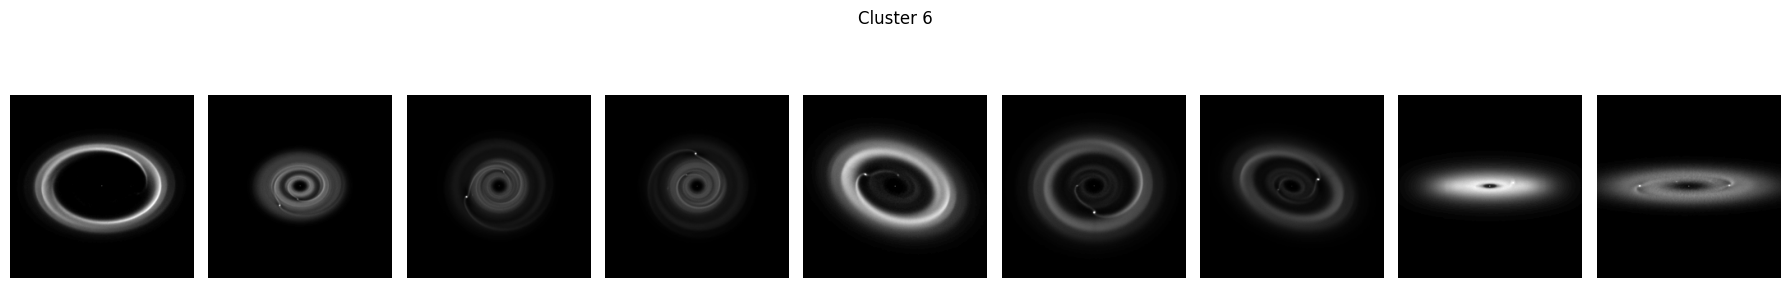

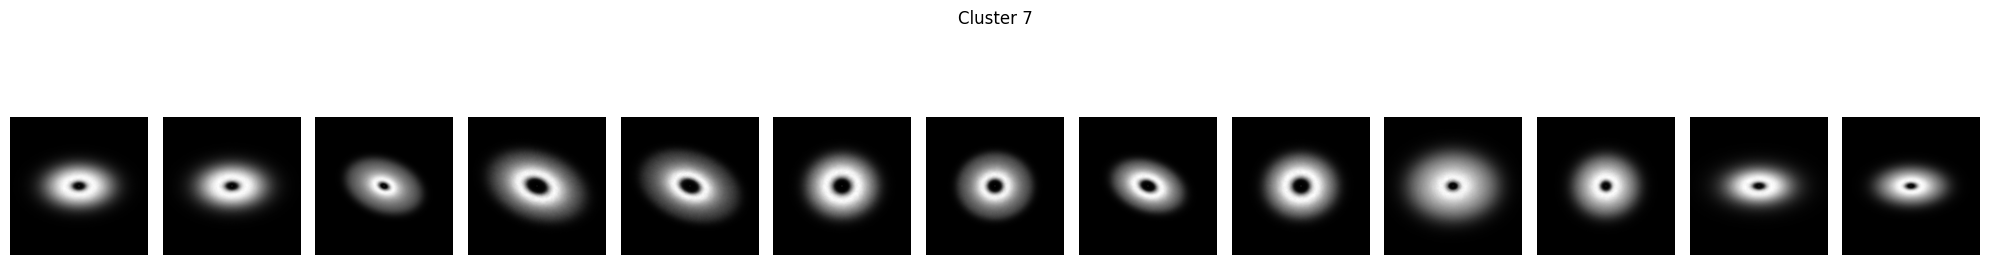

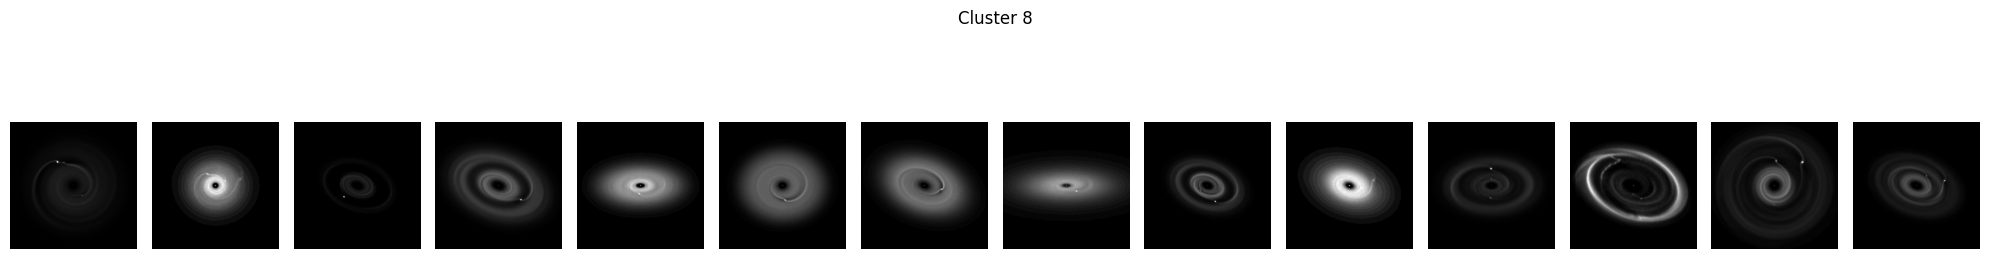

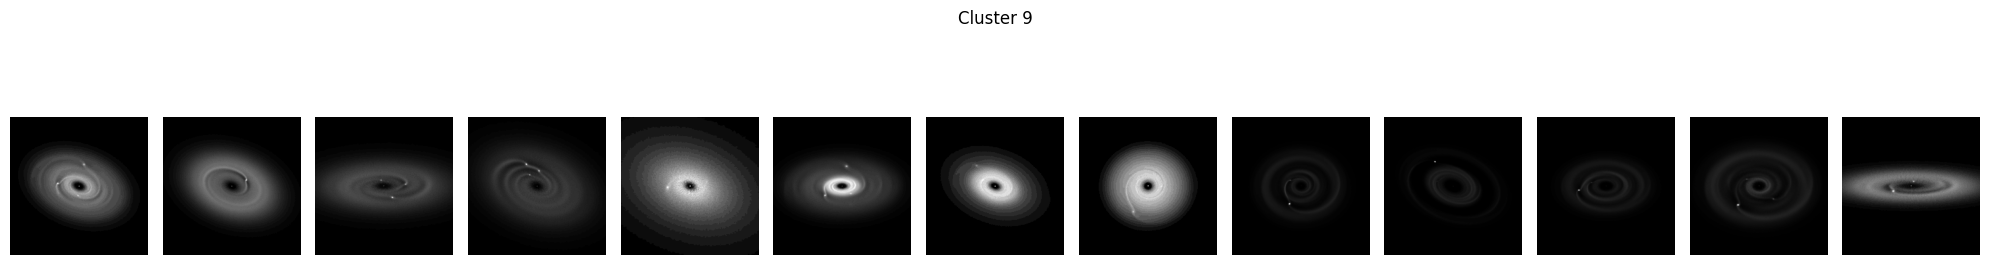

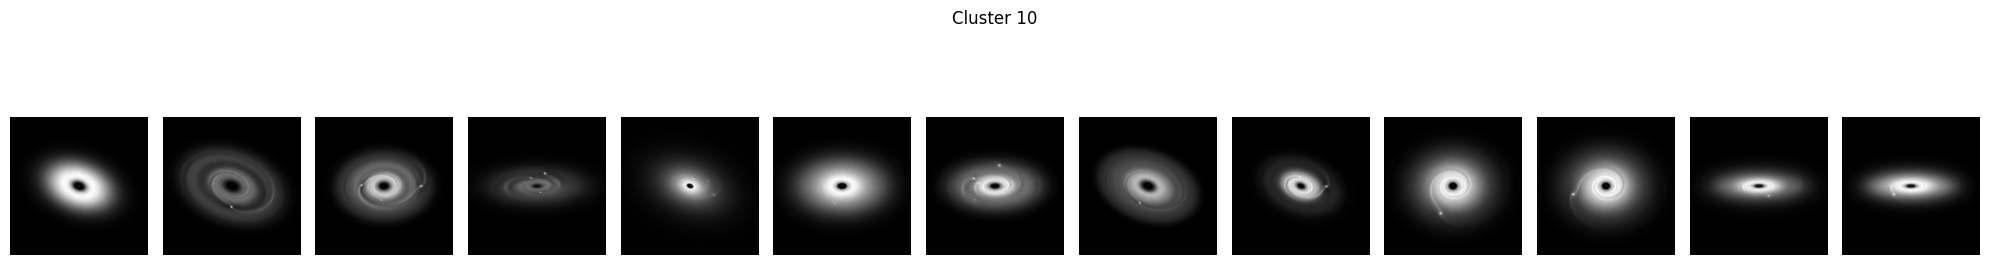

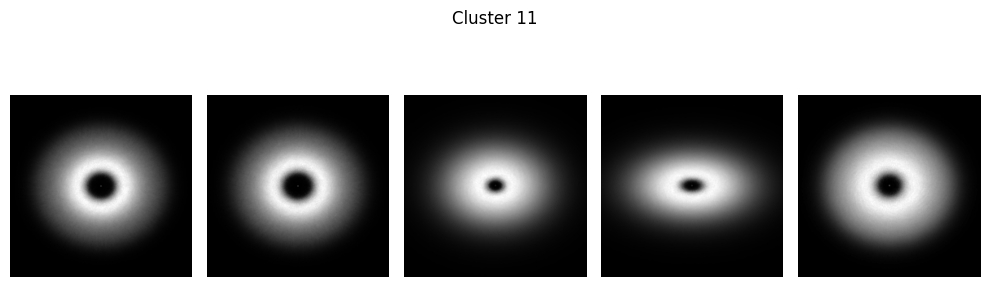

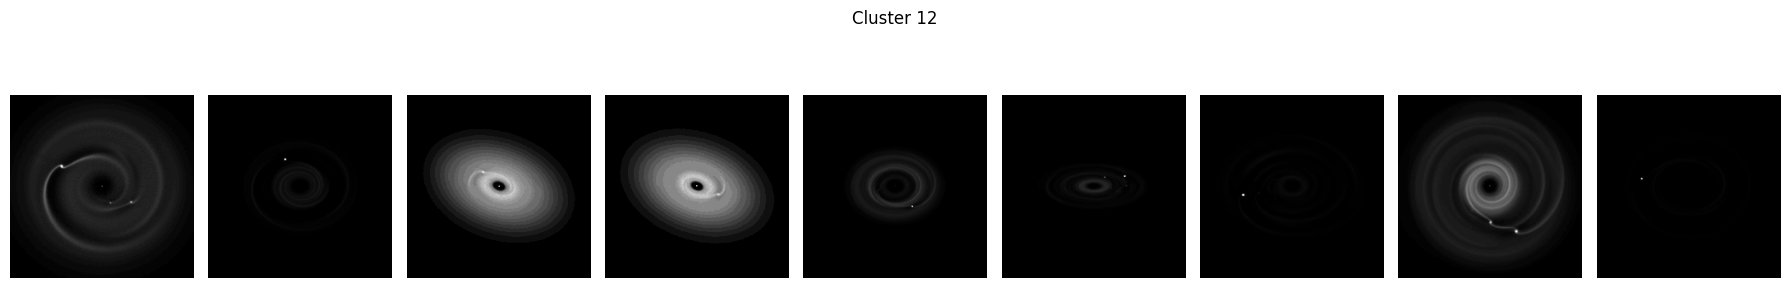

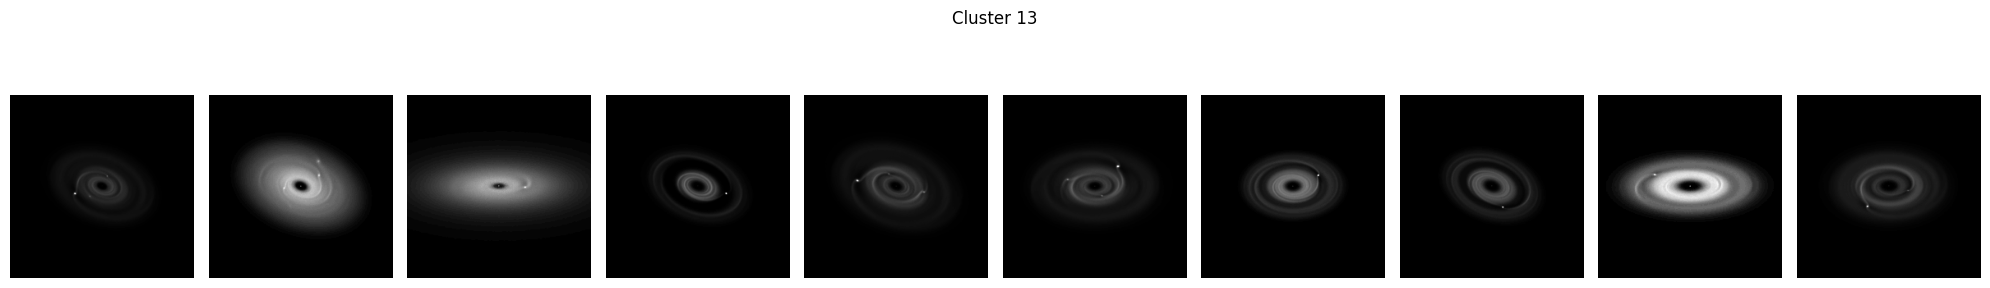

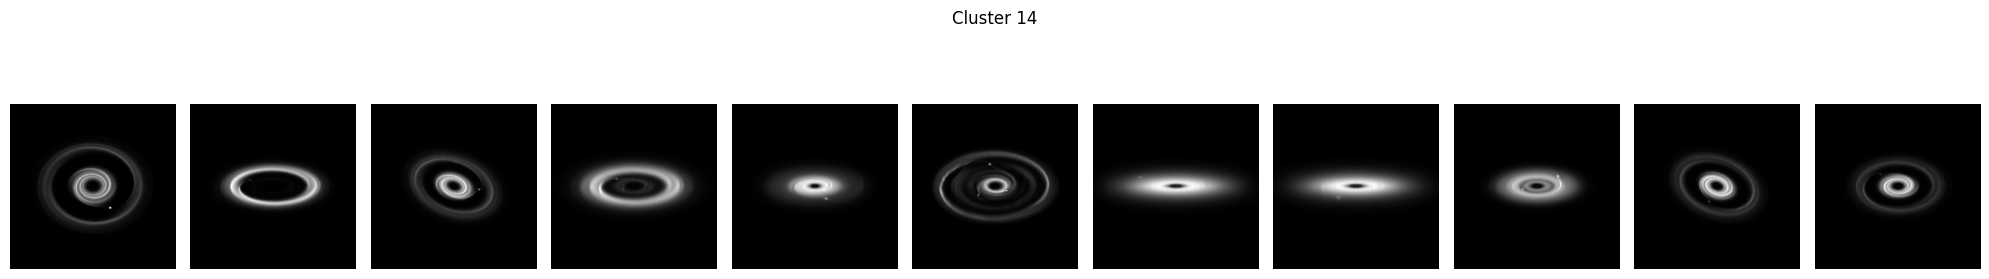

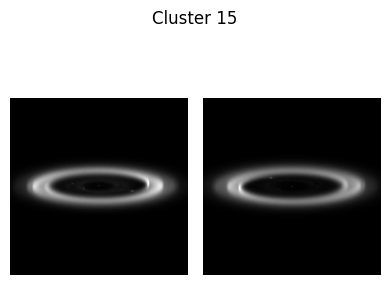

In [19]:
def plot_cluster(imgList, labels, n_clusters):
    for cluster in range(n_clusters):
        clusterList = np.where(labels == cluster)[0]

        fig, ax = plt.subplots(1, len(clusterList), figsize=(min(len(clusterList) * 2, 20), 4))

        if len(clusterList) == 1:
            ax = [ax]

        for i, idx in enumerate(clusterList):
            ax[i].imshow(imgList[idx].squeeze().numpy(), cmap='gray')
            ax[i].axis('off')

        plt.suptitle(f"Cluster {cluster+1}", y=0.85)
        plt.tight_layout(rect=[0, 0, 1, 0.9])
        plt.show()

plot_cluster(imgTensor, labels, num_clusters)
